# Data Loading and Integration

In [ ]:
pip install rarfile

In [45]:
import os
import glob
import json
import pandas as pd
import logging
from zipfile import ZipFile

def extract_zip(zip_path, extract_to):
    """Extracts the zip file."""
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def load_json_files(folder_path):
    """Loads and concatenates JSON files into a Pandas DataFrame, extracting nested data if needed."""
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    dataframes = []

    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = pd.read_json(f)

            logging.info(f"Processing {json_file}...")

            if 'response' in data.columns and isinstance(data['response'].iloc[3], list):
                nested_data = data['response'].iloc[3]
                df = pd.json_normalize(nested_data)
                dataframes.append(df)
                logging.info(f"Successfully normalized {json_file} with {len(df)} records and {len(df.columns)} features.")
            else:
                logging.warning(f"No relevant nested data found in {json_file}. Skipping.")
        except Exception as e:
            logging.error(f"Error processing {json_file}: {e}")

    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    return pd.DataFrame()

def load_csv_files(folder_path):
    """Loads and concatenates CSV files into a Pandas DataFrame."""
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    dataframes = []

    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file, encoding='utf-8')
            dataframes.append(df)
        except UnicodeDecodeError:
            df = pd.read_csv(csv_file, encoding='ISO-8859-1')
            dataframes.append(df)
        except Exception as e:
            logging.error(f"Error loading {csv_file}: {e}")

    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    return pd.DataFrame()

def main():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    zip_path = "raw.zip"
    extract_to = "raw_data/raw"
    extract_zip(zip_path, extract_to)

    electricity_folder = os.path.join(extract_to, "electricity_raw_data")
    weather_folder = os.path.join(extract_to, "weather_raw_data")

    electricity_df = load_json_files(electricity_folder)
    weather_df = load_csv_files(weather_folder)

    logging.info(f"Electricity Data: {electricity_df.shape[0]} records, {electricity_df.shape[1]} features")
    logging.info(f"Weather Data: {weather_df.shape[0]} records, {weather_df.shape[1]} features")

    # Merge the data if they share a common timestamp column
    if 'timestamp' in electricity_df.columns and 'timestamp' in weather_df.columns:
        combined_df = pd.merge(electricity_df, weather_df, on='timestamp', how='inner')
        logging.info(f"Merged Data: {combined_df.shape[0]} records, {combined_df.shape[1]} features")
    else:
        combined_df = pd.concat([electricity_df, weather_df], axis=1)
        logging.warning("No common timestamp found. Data concatenated instead of merged.")

    return combined_df

if __name__ == "__main__":
    combined_df = main()
    print(combined_df.head())

          period subba            subba-name parent  \
0  2024-08-14T00  ZONA           West - NYIS   NYIS   
1  2024-08-14T00  ZONB        Genesee - NYIS   NYIS   
2  2024-08-14T00  ZONC        Central - NYIS   NYIS   
3  2024-08-14T00  ZOND          North - NYIS   NYIS   
4  2024-08-14T00  ZONE  Mohawk Valley - NYIS   NYIS   

                            parent-name value    value-units  \
0  New York Independent System Operator  2004  megawatthours   
1  New York Independent System Operator  1349  megawatthours   
2  New York Independent System Operator  1973  megawatthours   
3  New York Independent System Operator   667  megawatthours   
4  New York Independent System Operator   940  megawatthours   

                  date  temperature_2m  
0  2024-01-14 05:00:00          1.7085  
1  2024-01-14 06:00:00          1.8085  
2  2024-01-14 07:00:00          1.4585  
3  2024-01-14 08:00:00          1.6585  
4  2024-01-14 09:00:00          2.0085  


# Preprocessing

In [46]:
print(combined_df.dtypes)

period             object
subba              object
subba-name         object
parent             object
parent-name        object
value              object
value-units        object
date               object
temperature_2m    float64
dtype: object


## a) Missing Data

In [47]:
missing_values = combined_df.isnull().sum()
missing_percentage = (missing_values / len(combined_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_df)

                Missing Values  Percentage
period                       0    0.000000
subba                        0    0.000000
subba-name                   0    0.000000
parent                       0    0.000000
parent-name                  0    0.000000
value                        0    0.000000
value-units                  0    0.000000
date                    174058   57.703503
temperature_2m          174214   57.755220


In [48]:
combined_df = combined_df.dropna()

## b) Data Type Conversions

In [49]:
combined_df['period'] = pd.to_datetime(combined_df['period'])

# Extract additional temporal features
combined_df['hour'] = combined_df['period'].dt.hour
combined_df['day'] = combined_df['period'].dt.day
combined_df['month'] = combined_df['period'].dt.month
combined_df['season'] = combined_df['month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
              'Spring' if x in [3, 4, 5] else
              'Summer' if x in [6, 7, 8] else 'Autumn'
)
# Convert categorical columns to pd.Categorical
categorical_cols = ['subba', 'subba-name', 'parent', 'parent-name', 'value-units']
for col in categorical_cols:
    combined_df[col] = pd.Categorical(combined_df[col])

combined_df['value'] = pd.to_numeric(combined_df['value'], errors='coerce')

In [50]:
combined_df.head()

,period,subba,subba-name,parent,parent-name,value,value-units,date,temperature_2m,hour,day,month,season
0,2024-08-14,ZONA,West - NYIS,NYIS,New York Independent System Operator,2004,megawatthours,2024-01-14 05:00:00,1.7085,0,14,8,Summer
1,2024-08-14,ZONB,Genesee - NYIS,NYIS,New York Independent System Operator,1349,megawatthours,2024-01-14 06:00:00,1.8085,0,14,8,Summer
2,2024-08-14,ZONC,Central - NYIS,NYIS,New York Independent System Operator,1973,megawatthours,2024-01-14 07:00:00,1.4585,0,14,8,Summer
3,2024-08-14,ZOND,North - NYIS,NYIS,New York Independent System Operator,667,megawatthours,2024-01-14 08:00:00,1.6585,0,14,8,Summer
4,2024-08-14,ZONE,Mohawk Valley - NYIS,NYIS,New York Independent System Operator,940,megawatthours,2024-01-14 09:00:00,2.0085,0,14,8,Summer


## c) Handling Duplicates and Inconsistencies

In [51]:
# Detect and remove duplicate rows
duplicates = combined_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
combined_df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


## d) Feature Engineering:

In [52]:
from sklearn.preprocessing import MinMaxScaler

combined_df['day_of_week'] = combined_df['period'].dt.dayofweek  # Monday=0, Sunday=6
combined_df['is_weekend'] = combined_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Normalize the 'value' column (optional)
scaler = MinMaxScaler()
combined_df['value_normalized'] = scaler.fit_transform(combined_df[['value']])

combined_df.head()

,period,subba,subba-name,parent,parent-name,value,value-units,date,temperature_2m,hour,day,month,season,day_of_week,is_weekend,value_normalized
0,2024-08-14,ZONA,West - NYIS,NYIS,New York Independent System Operator,2004,megawatthours,2024-01-14 05:00:00,1.7085,0,14,8,Summer,2,0,0.179625
1,2024-08-14,ZONB,Genesee - NYIS,NYIS,New York Independent System Operator,1349,megawatthours,2024-01-14 06:00:00,1.8085,0,14,8,Summer,2,0,0.115403
2,2024-08-14,ZONC,Central - NYIS,NYIS,New York Independent System Operator,1973,megawatthours,2024-01-14 07:00:00,1.4585,0,14,8,Summer,2,0,0.176586
3,2024-08-14,ZOND,North - NYIS,NYIS,New York Independent System Operator,667,megawatthours,2024-01-14 08:00:00,1.6585,0,14,8,Summer,2,0,0.048534
4,2024-08-14,ZONE,Mohawk Valley - NYIS,NYIS,New York Independent System Operator,940,megawatthours,2024-01-14 09:00:00,2.0085,0,14,8,Summer,2,0,0.075302


# Exploratory Data Analysis (EDA)

## Statistical Summary

In [53]:
# For numerical features
numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
statistical_summary = combined_df[numerical_cols].describe()

# Add skewness and kurtosis
statistical_summary.loc['skewness'] = combined_df[numerical_cols].skew()
statistical_summary.loc['kurtosis'] = combined_df[numerical_cols].kurt()

print("Statistical Summary:")
print(statistical_summary)

Statistical Summary:
                  value  temperature_2m     is_weekend  value_normalized
count     127428.000000   127428.000000  127428.000000     127428.000000
mean        1565.966389        8.542398       0.264494          0.136677
std         1453.911129        7.999818       0.441065          0.142554
min          172.000000      -10.491500       0.000000          0.000000
25%          705.000000        2.658500       0.000000          0.052260
50%         1131.000000        7.308500       0.000000          0.094029
75%         1737.000000       13.908501       1.000000          0.153446
max        10371.000000       37.708500       1.000000          1.000000
skewness       2.377923        0.470666       1.067911          2.377923
kurtosis       5.742107       -0.251833      -0.859580          5.742107


## Time Series Analysis

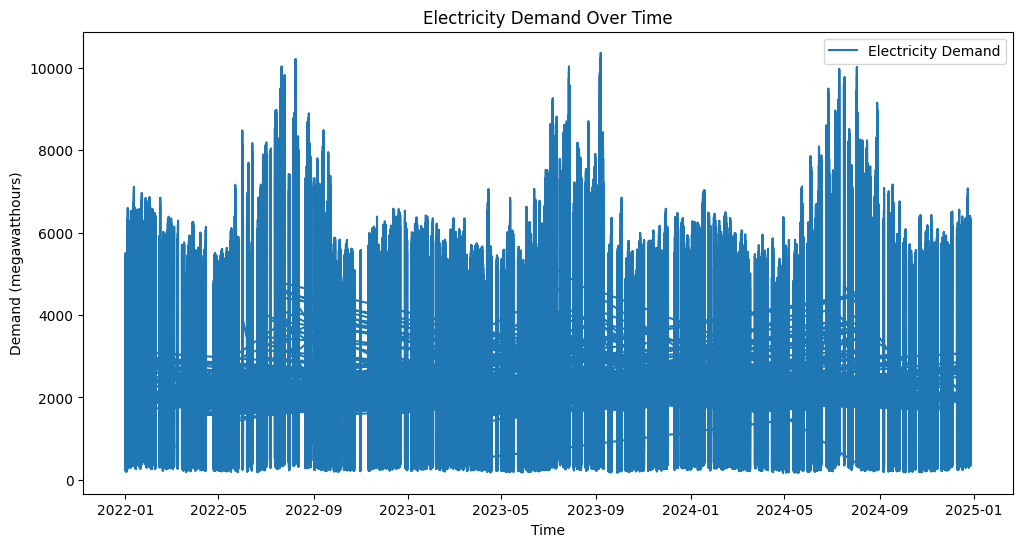

In [54]:
import matplotlib.pyplot as plt

# Plot electricity demand over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['period'], combined_df['value'], label='Electricity Demand')
plt.title('Electricity Demand Over Time')
plt.xlabel('Time')
plt.ylabel('Demand (megawatthours)')
plt.legend()
#plt.grid(True)
plt.show()

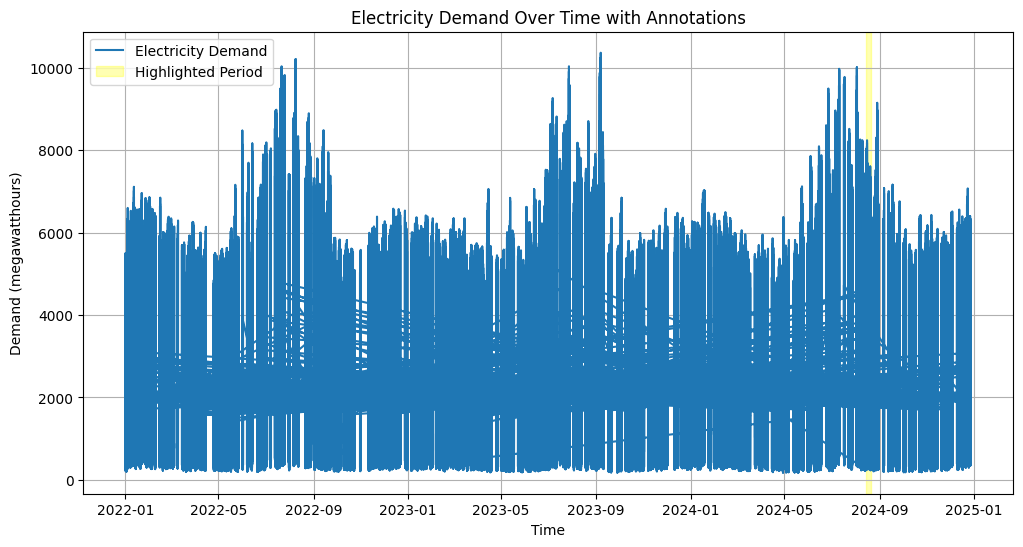

In [55]:
# Annotate trends and seasonal patterns
# Example: Highlight a specific period
plt.figure(figsize=(12, 6))
plt.plot(combined_df['period'], combined_df['value'], label='Electricity Demand')
plt.axvspan(pd.to_datetime('2024-08-14'), pd.to_datetime('2024-08-21'), color='yellow', alpha=0.3, label='Highlighted Period')
plt.title('Electricity Demand Over Time with Annotations')
plt.xlabel('Time')
plt.ylabel('Demand (megawatthours)')
plt.legend()
plt.grid(True)
plt.show()

## Univariate Analysis:

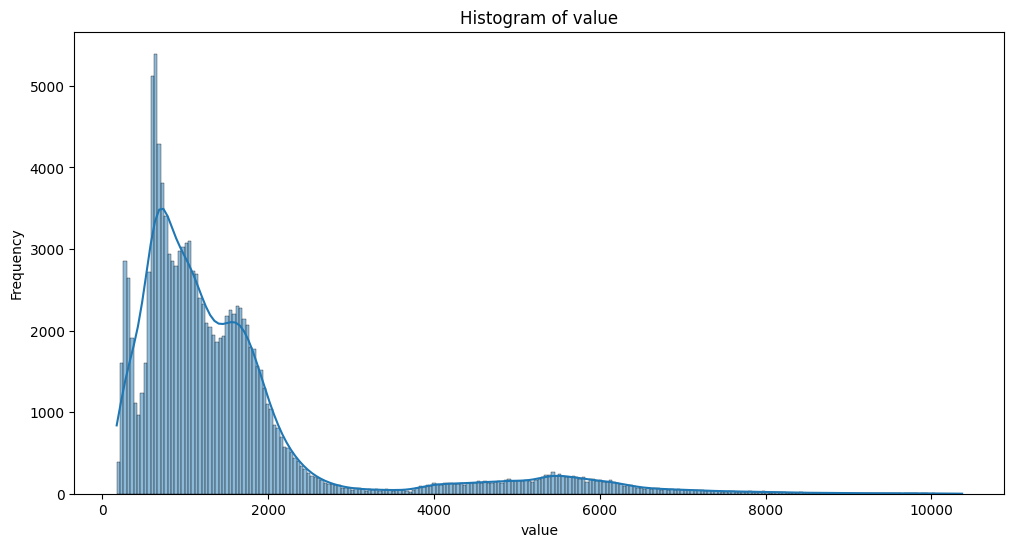

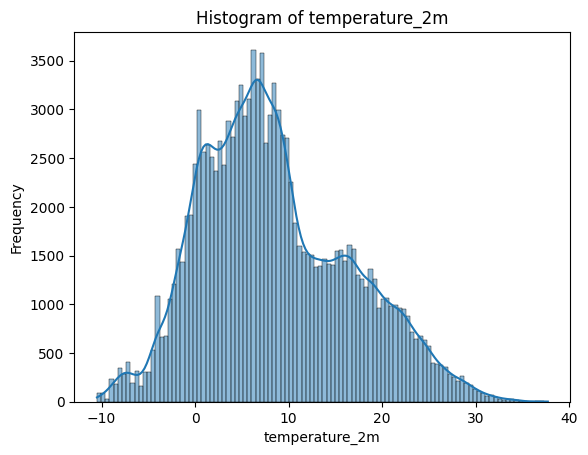

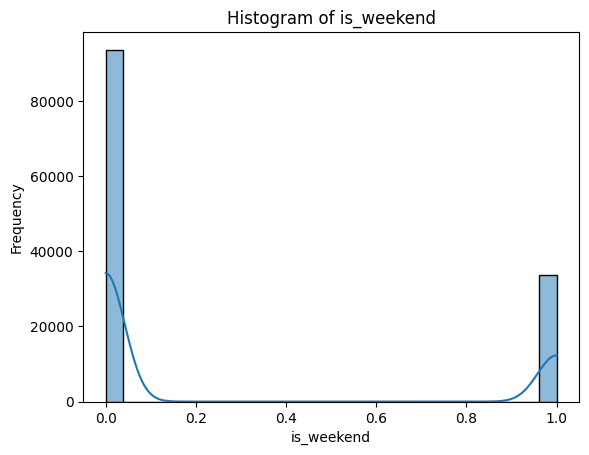

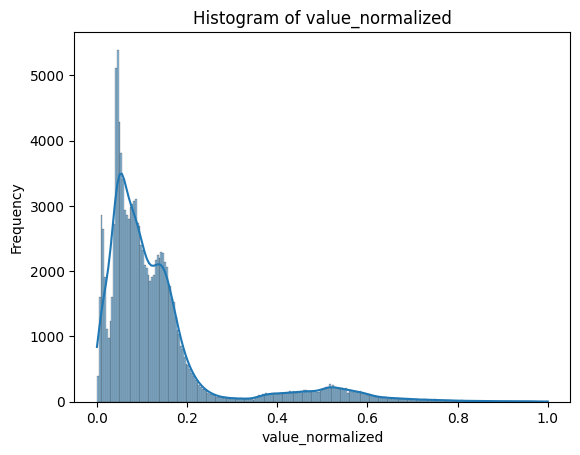

In [56]:
import seaborn as sns

# Histograms
plt.figure(figsize=(12, 6))
for col in numerical_cols:
    sns.histplot(combined_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

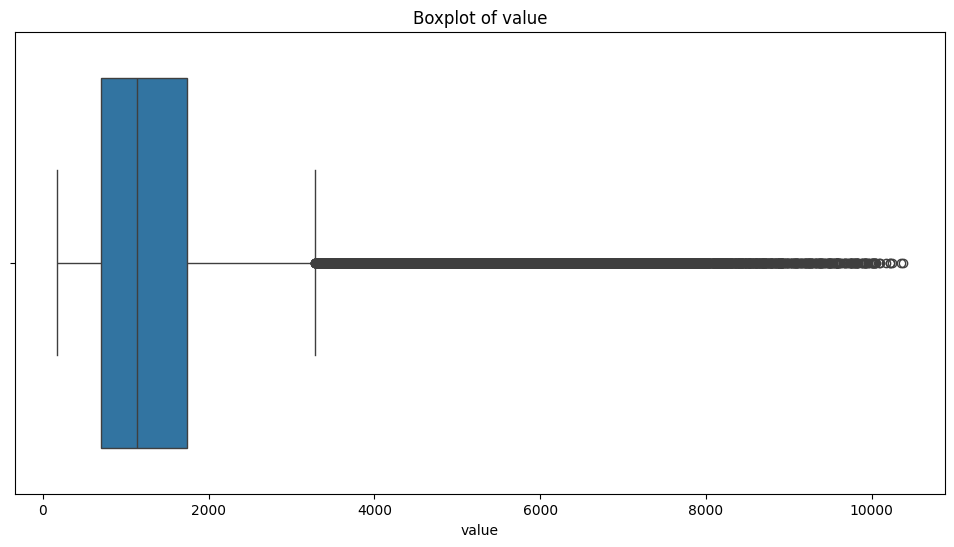

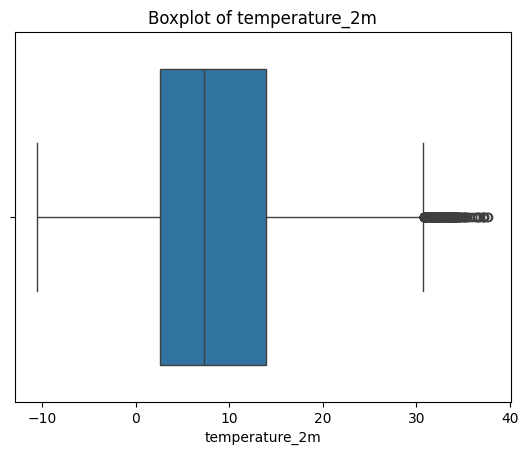

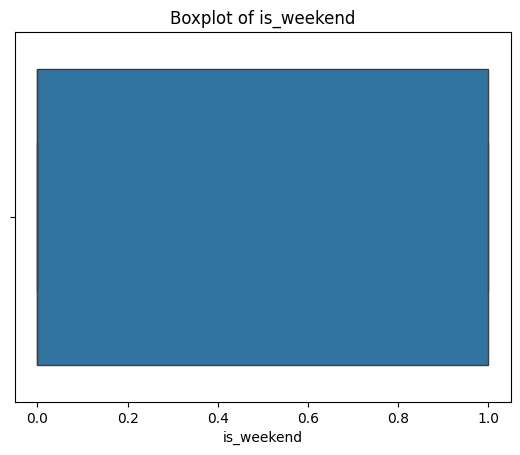

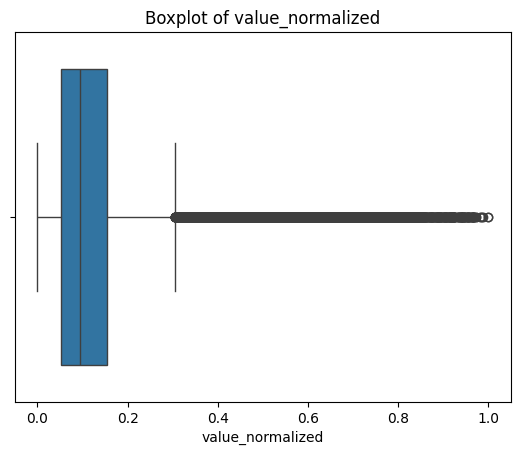

In [57]:
# Boxplots
plt.figure(figsize=(12, 6))
for col in numerical_cols:
    sns.boxplot(x=combined_df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

<ipython-input-58-e0f3fce5de9d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_df[col], shade=True)


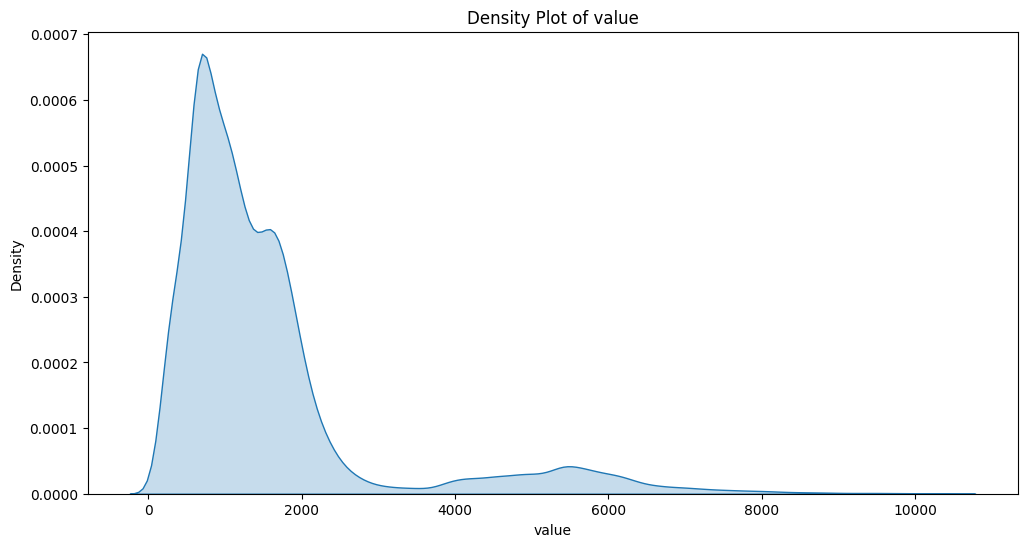

<ipython-input-58-e0f3fce5de9d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_df[col], shade=True)


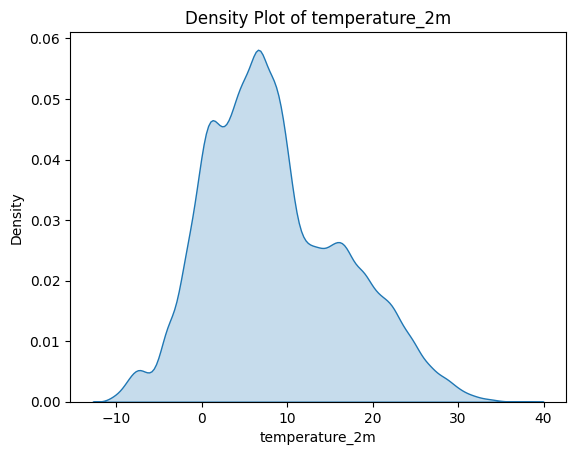

<ipython-input-58-e0f3fce5de9d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_df[col], shade=True)


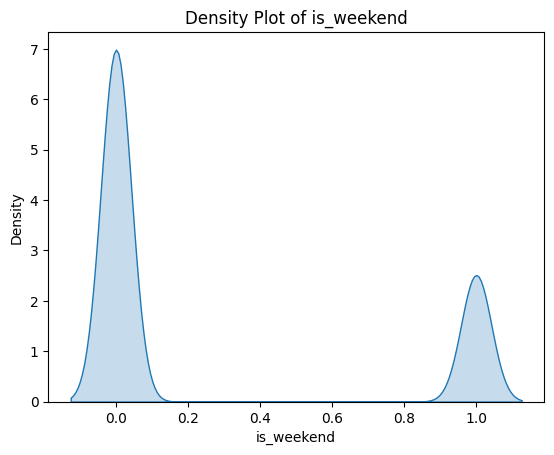

<ipython-input-58-e0f3fce5de9d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_df[col], shade=True)


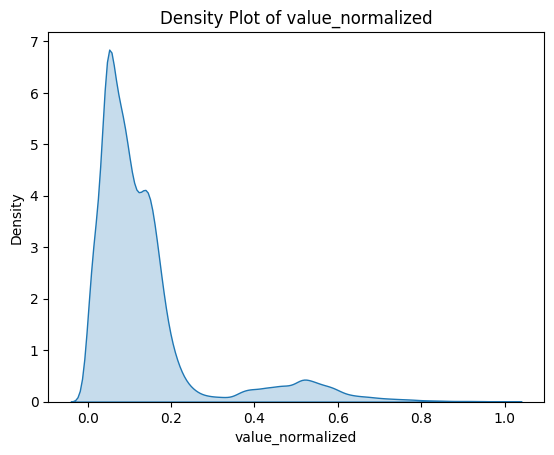

In [58]:
# Density plots
plt.figure(figsize=(12, 6))
for col in numerical_cols:
    sns.kdeplot(combined_df[col], shade=True)
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

## Correlation Analysis

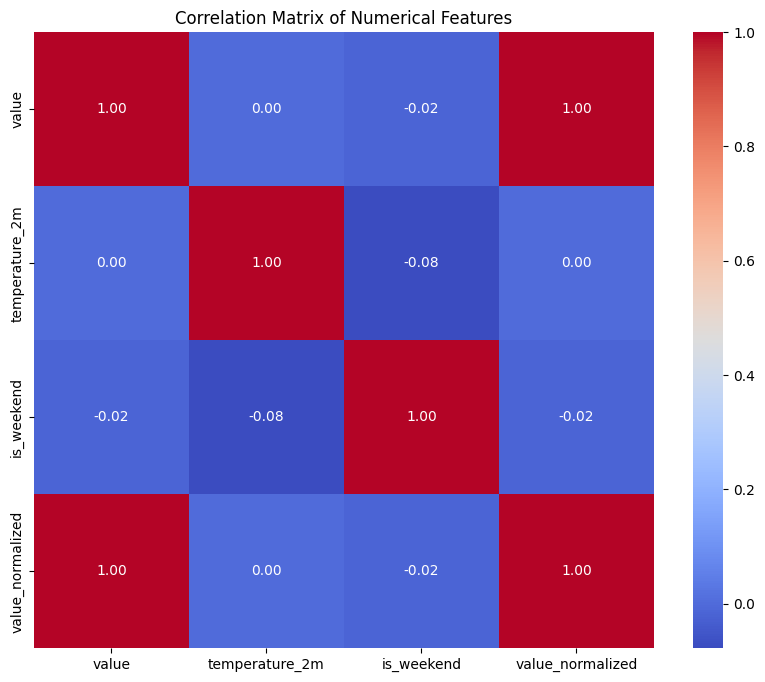

In [59]:
# Compute correlation matrix
correlation_matrix = combined_df[numerical_cols].corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [60]:
# Identify multicollinearity issues
# Example: If two features have a correlation > 0.8 or < -0.8, they may be highly collinear
high_correlation = correlation_matrix[(correlation_matrix > 0.8) | (correlation_matrix < -0.8)]
print("Highly Correlated Features:")
print(high_correlation)

Highly Correlated Features:
                  value  temperature_2m  is_weekend  value_normalized
value               1.0             NaN         NaN               1.0
temperature_2m      NaN             1.0         NaN               NaN
is_weekend          NaN             NaN         1.0               NaN
value_normalized    1.0             NaN         NaN               1.0


## Advanced Time Series Techniques

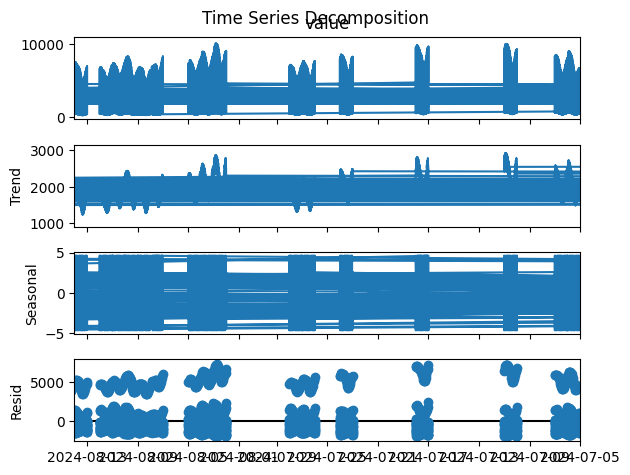

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# Time series decomposition
if 'period' in combined_df.columns:
    combined_df.set_index('period', inplace=True)
    decomposition = seasonal_decompose(combined_df['value'], model='additive', period=24)  # Assuming hourly data
    decomposition.plot()
    plt.suptitle('Time Series Decomposition')
    plt.show()

# Outlier Detection and Handling

## IQR-based Detection

In [62]:
import numpy as np

# Select numerical columns for outlier detection
num_columns = combined_df.select_dtypes(include=[np.number]).columns

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df[num_columns].quantile(0.25)
Q3 = combined_df[num_columns].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = ((combined_df[num_columns] < lower_bound) | (combined_df[num_columns] > upper_bound))

# Count outliers per feature
outliers_iqr.sum()

,0
value,12520
temperature_2m,372
hour,0
day,0
month,0
day_of_week,0
is_weekend,0
value_normalized,12520


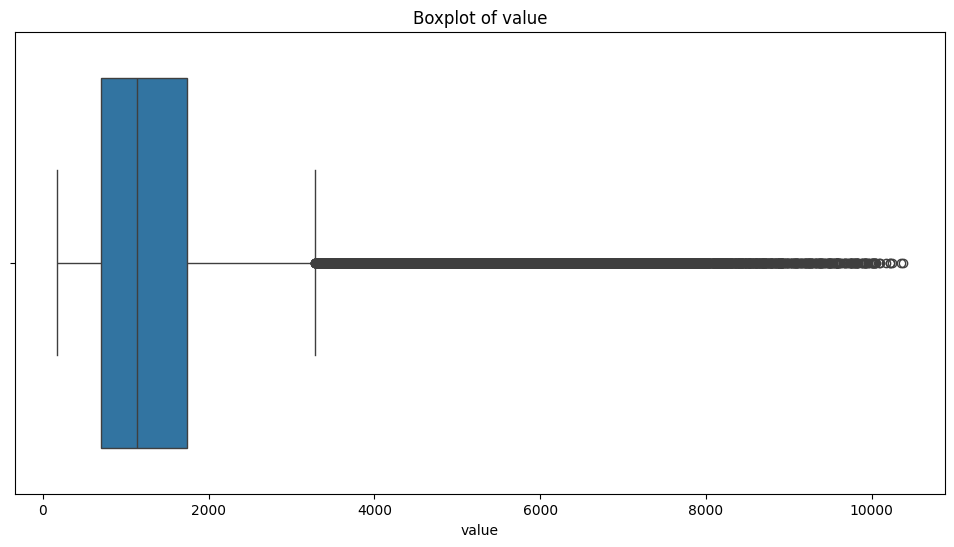

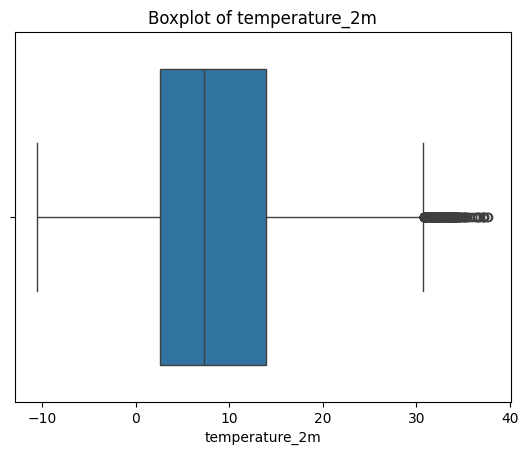

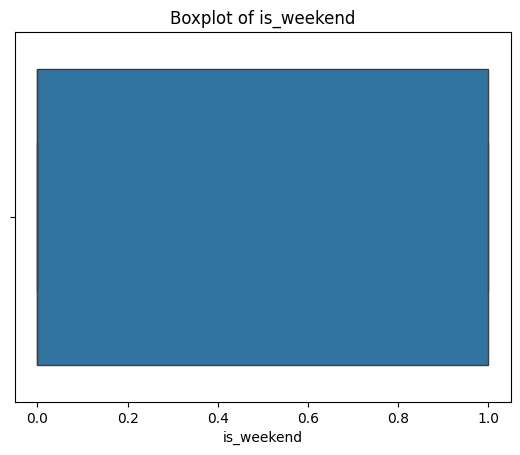

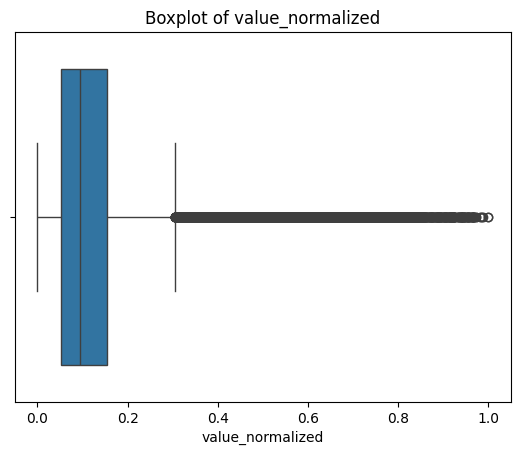

In [63]:
# Boxplots
plt.figure(figsize=(12, 6))
for col in numerical_cols:
    sns.boxplot(x=combined_df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

## Z-score Method

In [64]:
from scipy.stats import zscore

z_scores = zscore(combined_df['value'])
# Use combined_df instead of data
outliers = combined_df[np.abs(z_scores) > 3]
print(f"Outliers in 'value' using Z-score: {len(outliers)}")

Outliers in 'value' using Z-score: 3748


In [65]:
combined_df['value_capped'] = combined_df['value'].apply(lambda x: min(max(x, lower_bound['value']), upper_bound['value']))

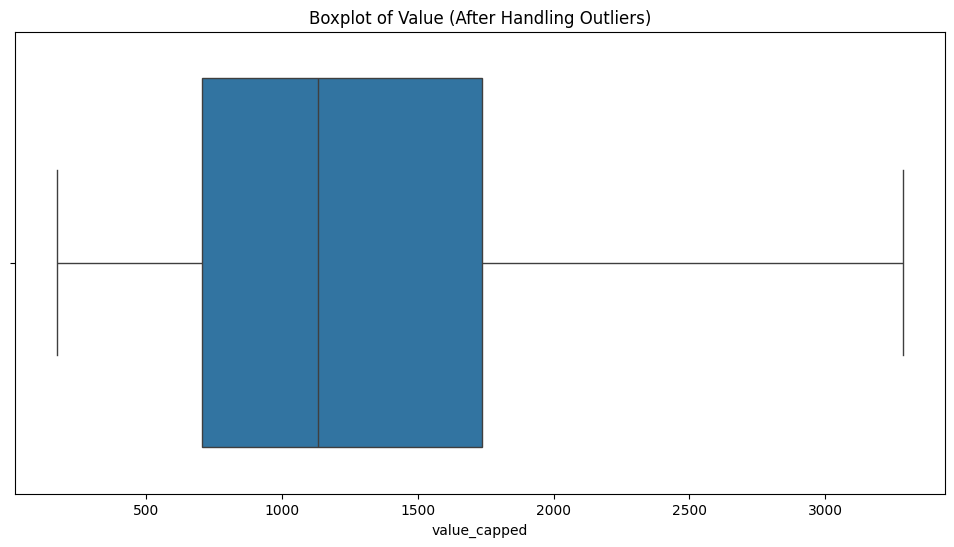

In [66]:
# Visualize the distribution after handling outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=combined_df['value_capped'])
plt.title('Boxplot of Value (After Handling Outliers)')
plt.show()

# Regression Modeling

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select predictor variables (features)
features = ['hour', 'day', 'month', 'day_of_week', 'temperature_2m']

# Define the target variable (electricity demand)
target = 'value'

# Create feature matrix (X) and target vector (y)
X = combined_df[features]
y = combined_df[target]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

## Evaluation

In [68]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

Model Evaluation Metrics:
MSE: 2098913.69133734
RMSE: 1448.762814037322
R² Score: 0.00018065173864556527


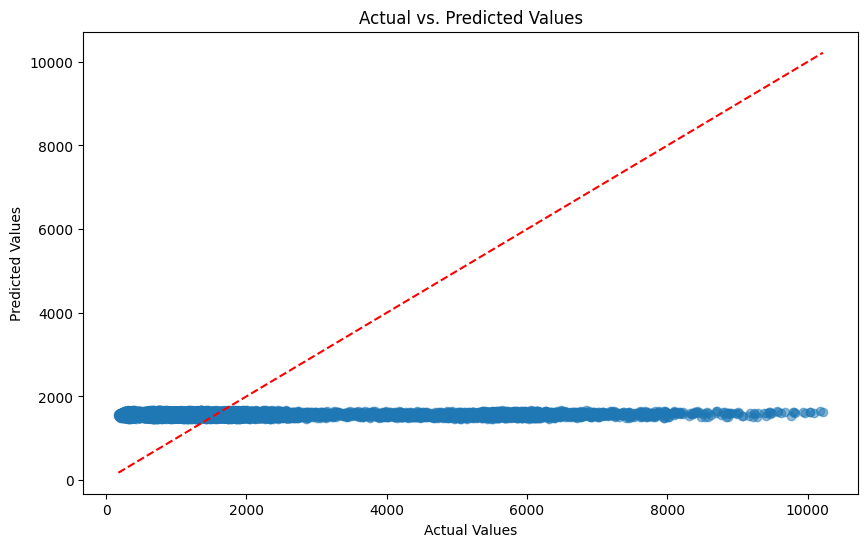

In [69]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

## Residual Analysis

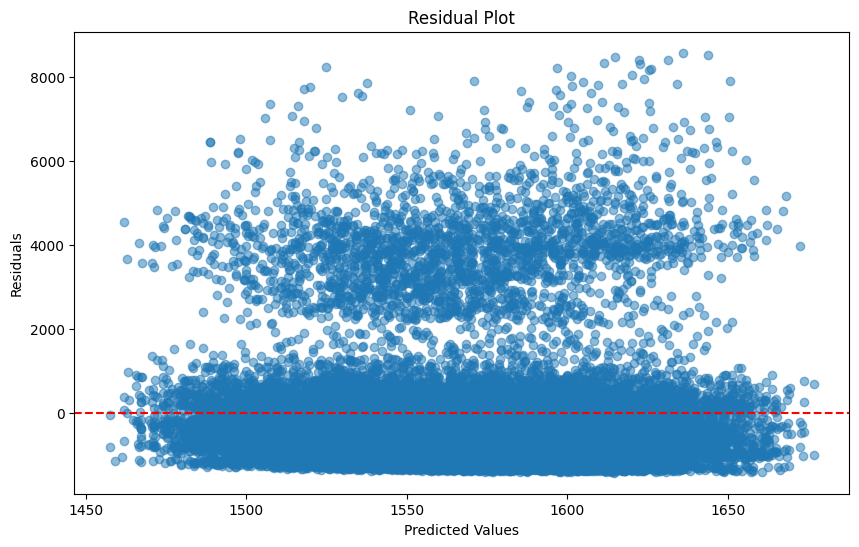

In [70]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at 0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

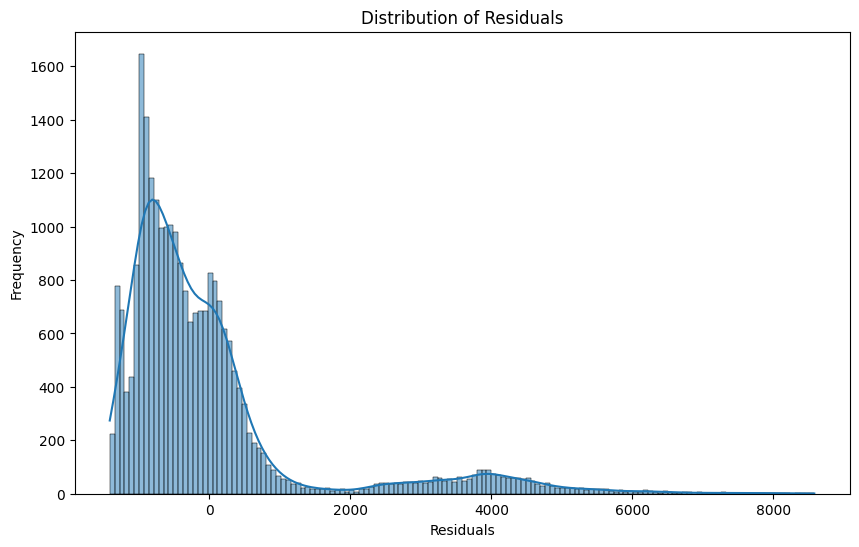

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [72]:
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print("Feature Coefficients:")
print(coefficients)

Feature Coefficients:
          Feature  Coefficient
0            hour     4.215069
1             day     0.669629
2           month     4.293433
3     day_of_week    -9.983704
4  temperature_2m    -0.095453
